# Understanding CNNs with CIFAR10

## Models included: Inception, ResNet, DenseNet

## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial5

### Boilerplate

In [2]:
## Standard libraries
import os
import numpy as np 
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import pytorch_lightning as pl
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_85218/2503179501.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Using device", device)

Using device mps


In [3]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "./saved_models"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

In [7]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('test_acc', acc)

In [144]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

In [10]:
def train_model(model_name, save_name=None, **kwargs):
    if save_name is None:
        save_name = model_name
        
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          
                         accelerator="gpu" if str(device).startswith("cuda") or str(device).startswith("mps") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          
                         max_epochs=180,                                                                     
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  
                                    LearningRateMonitor("epoch")],                                           
                         enable_progress_bar=True)                                                           
    trainer.logger._log_graph = True         
    trainer.logger._default_hp_metric = None 
    
    pl.seed_everything(42) # To be reproducable
    model = CIFARModule(model_name=model_name, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) 
        
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

### Data

In [13]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
print(train_dataset.data.shape)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2)) # collapse first 3 axes
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

100%|███████████████████████████████████████████████████████████████████████| 170M/170M [00:49<00:00, 3.43MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
(50000, 32, 32, 3)
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [14]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
imgs, _ = next(iter(train_loader))
print(imgs.shape)
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

torch.Size([128, 3, 32, 32])
Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


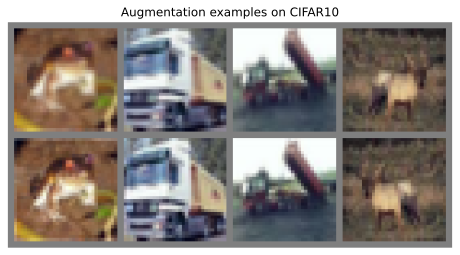

In [16]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

### Inception

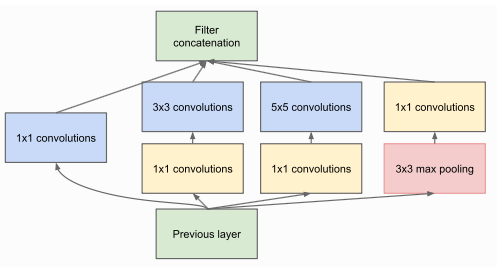

- The 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction.
- This is useful to keep the number of channels mostly constant, since features are merged afterward.
- As 5x5 convolutions are 25 times more expensive than 1x1 convolutions, we also save a lot of computation and parameters by reducing the dimensionality before the large convolutions.

In [ ]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]), # Equivalent to taking mean and sd over dims = (0,2,3)
            act_fn()
        )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [ ]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

The number of channels for dimensionality reduction and output per filter are manually specified for this use case. 

In [146]:
model_dict["GoogleNet"] = GoogleNet

In [141]:
# Code to run, we do not train this model
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

### ResNet

Instead of modeling $x_{l+1}=F(x_{l})$, we model $x_{l+1}=x_{l}+F(x_{l})$ where $F$ is a non-linear mapping. If we do backpropagation on such residual connections, we obtain:

$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}$

The bias towards the identity matrix guarantees a stable gradient propagation being less effected by $F$ itself.

The original ResNet block applies a non-linear activation function, usually ReLU, after the skip connection. In contrast, the pre-activation ResNet block applies the non-linearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep network, however, the pre-activation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it.

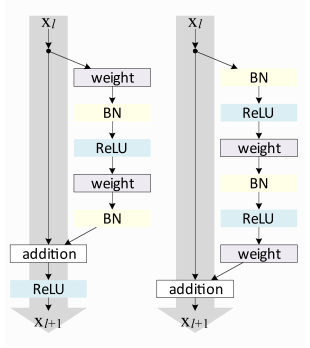

In [10]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
            
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

In [12]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
            
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        
        # 1x1 convolution can apply non-linearity as well, but not strictly necessary
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [14]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

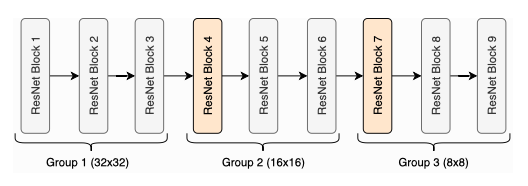

In [ ]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )
        
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [ ]:
model_dict["ResNet"] = ResNet

In [ ]:
resnet_model, resnet_results = train_model(model_name="ResNet", 
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"}, 
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

### DenseNet

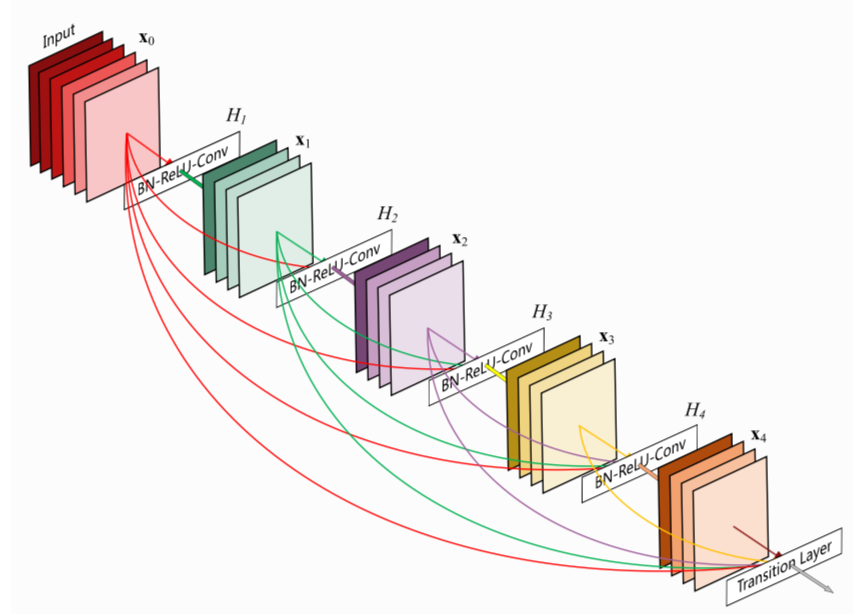

To me, this is very similar to pre-activation ResNet. A few ways that DenseNet is different is that 
- It concatenates rather than adds. I view this as allowing more flexible weights to be applied. ResNet probably has the ability to learn the same formulation, but it might be harder to learn.
- It is more parameter efficient. Empirically, it achieves similar performance to ResNet with fewer parameters. 

The last layer, called the transition layer, is responsible for reducing the dimensionality of the feature maps in height, width, and channel size. Although those technically break the identity backpropagation, there are only a few in a network so that it doesn't affect the gradient flow much.

In [8]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
        growth_rate - Number of output channels of the 3x3 convolution
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

Here, we apply a 1x1 convolution for dimensionality reduction (to dimension `bn_size`*`growth_rate`) with a subsequential 3x3 convolution (to dimension `growth_rate`). 

In [10]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

In [12]:
class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )
        
    def forward(self, x):
        return self.transition(x)

In [14]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [20]:
model_dict["DenseNet"] = DenseNet

In [ ]:
densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})